<a href="https://colab.research.google.com/github/Nick-FF/NeuroNets_Begining/blob/Less4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Разбор ДЗ4
Вариант 2. (сложный)
    1. реализовать нейронную сеть в схеме AlexNet на сifar10.
    2. оценить рост точности при увеличении ширины сети (больше ядер)
    3. оценить рост точности при увеличении глубины сети (больше слоев)


In [12]:
# The full neural network code!
###############################
import numpy as np
import pandas as pd
#import mnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10





Можно обрабатывать данные - это улучшит результат. 



In [13]:
(train_images,train_labels),(test_images,test_labels)=cifar10.load_data()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.


train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
#

In [14]:
from tensorflow.keras.models import Model 

## AlexNet

https://habr.com/ru/company/nix/blog/430524/


Использование блоков линейной ректификации (ReLU) в качестве нелинейностей.

Использование методики отбрасывания для выборочного игнорирования отдельных нейронов в ходе обучения, что позволяет избежать переобучения модели.

Перекрытие max pooling, что позволяет избежать эффектов усреднения average pooling.

In [15]:
# соберу генерацию модели в функцию
def neuron_net(layerList = [8,16,32,64,128], kernel_size_=[5,3,3,3,3]):
  # Используеv функциональное API
  # первый слой всегда 32х32х3 входов
  
  # в передаваемых параметрах :layerList = [8,16,32,64,128] - число ядер по слоям, в kernel_size_=[5,3,3,3,3] - размеры ядер по слоям
  # инициализация  модели
  input1= tensorflow.keras.layers.Input(shape=(32,32,3))
  # первый сверточный слой
  x1 = tensorflow.keras.layers.Conv2D(layerList[0], kernel_size=(kernel_size_[0], kernel_size_[0]), strides=(1, 1), activation='relu',  padding="same")(input1)
  # второй пуллинговый слой
  x2 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x1)

  # третий сверточный слой
  x3 = tensorflow.keras.layers.Conv2D(layerList[1], kernel_size=(kernel_size_[1], kernel_size_[1]), strides=(1, 1), activation='relu', padding='same')(x2)

  # четвертый пуллинговый слой
  x4 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x3)

  # пятый блок  слоев свертки без изменения размеров
  x5 = tensorflow.keras.layers.Conv2D(layerList[2], kernel_size=(kernel_size_[2], kernel_size_[2]), strides=(1, 1), activation='relu', padding='same')(x4)
  x5 = tensorflow.keras.layers.Conv2D(layerList[3], kernel_size=(kernel_size_[3], kernel_size_[3]), strides=(1, 1), activation='relu', padding='same')(x5)
  x5 = tensorflow.keras.layers.Conv2D(layerList[4], kernel_size=(kernel_size_[4], kernel_size_[4]), strides=(1, 1), activation='relu', padding='same')(x5)
  x5 = tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x5)

  # векторизирую CNN выход, чтобы можно было его присоединить к полносвязногому слою
  x6 = tensorflow.keras.layers.Flatten()(x5)

  # шестой полносвязный слой
  x7 = tensorflow.keras.layers.Dense(84, activation='relu')(x6)

  # выходной слой с функцией активации softmax
  out_x = tensorflow.keras.layers.Dense(10, activation='softmax')(x7)

  model = Model(inputs = input1, outputs = out_x)
  model3 = Model(inputs = input1, outputs = x3) # эТО ДЛЯ ПОСМОТРЕТЬ ВНУТРИ
  model5 = Model(inputs = input1, outputs = x5)  # эТО ДЛЯ ПОСМОТРЕТЬ ВНУТРИ
# компилияция модели
  model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

  return model, model3,model5

In [16]:
from IPython.core.pylabtools import retina_figure
### Эксперимент
def expirience(batch_size_list, epoch_list, neuron_list, layerList_tail):
  Error_exp_ = pd.DataFrame(data=np.array([[0,0,0,0,0]]),columns = ['neuron','batch_size','epoch','error','accuracy'])
  for epochs in epoch_list:
    
    ik=0
    for neuron_ in neuron_list:
      # меняю число нейронов скрытого слоя
      #print(neuron_)
      for batch_size_ in batch_size_list:
        # меняю размер пакета для обучения
        eerors = []
        acc =[]
        for j in range(3):
          # будем делать несколько перезапусков - сейчас 3
          
          # создаем сеть
          model, model3,model5 = neuron_net(layerList = [neuron_]+layerList_tail,kernel_size_=[5,3,3,3,3])
          # учим сеть и проверяем сразу, т.к. включаю validation_split=0.2
          history = model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
          # записываю результаты валидации, а не обучения - это честно
          eerors.append(history.history['val_loss'][-1])
          acc.append(history.history['val_accuracy'][-1])
        # Табличка !!!! 
        Error_exp_.loc[ik,['neuron','batch_size','epoch','error','accuracy']] = [neuron_,batch_size_,epochs ,np.mean(eerors),np.mean(acc)]
        ik +=1


  # Predict on the first 5 test images.
  predictions = model.predict(test_images[:5])

  # Print our model's predictions.
  print(np.argmax(predictions, axis=1)) # [7, 2, 1, 0, 4]

  # Check our predictions against the ground truths.
  print(test_labels[:5]) # [7, 2, 1, 0, 4]
  return Error_exp_ 

In [17]:
import matplotlib.pyplot as plt
def plotter(epoch, batch_size, Error_exp_pass):
  # ГРАФИКИ !!!!! - это будет точность от числа нейронов по размерам пакетов(batch_size)
  for epoh in epoch:
    plt.figure(figsize=(16,5))
    plt.title(f'epoch {epoh}')
    for batch_s in batch_size:
      filter=[Error_exp_pass['epoch']==epoh & Error_exp_pass['batch_size']==batch_s,['neuron','accuracy']]
      plt.xlabel('neuron')
      plt.ylabel('accuracy')
      plt.plot(filter['neuron'],filter['accuracy'],label = f'batch_size = {batch_s}')
    print(filter)
    plt.legend()
    plt.show()    

Вариант с layerList_tail=[16,32,64,128]

In [ ]:
batch_size_list = [50, 100,200]
epoch_list = [100, 150, 200]
neuron_list=[64,128]
layerList_tail=[16,32,64,128]
Error_exp_=expirience(batch_size_list, epoch_list, neuron_list, layerList_tail)
plotter(epoch_list, batch_size_list, Error_exp_)

In [1]:
Error_exp_

NameError: ignored

[3 8 0 0 4]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


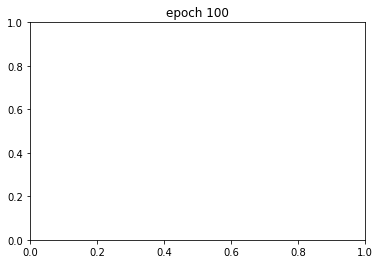

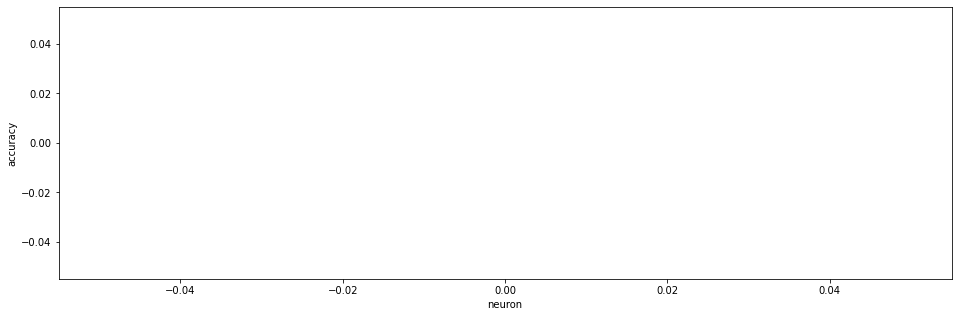

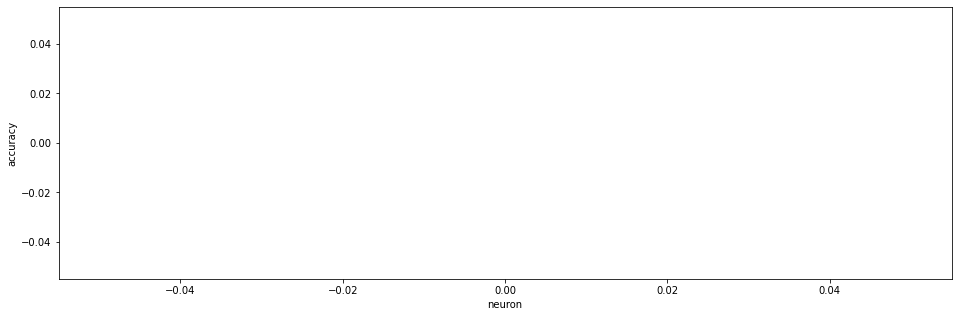

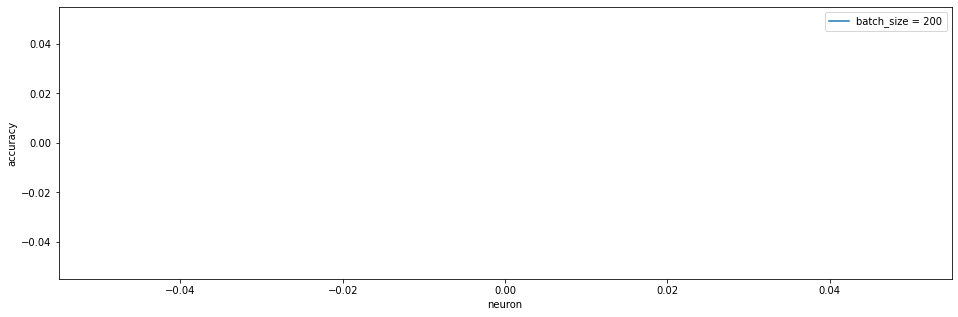

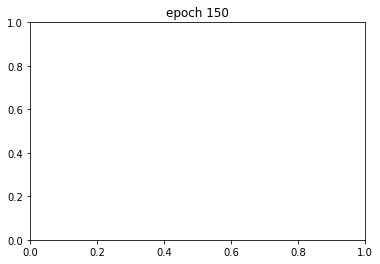

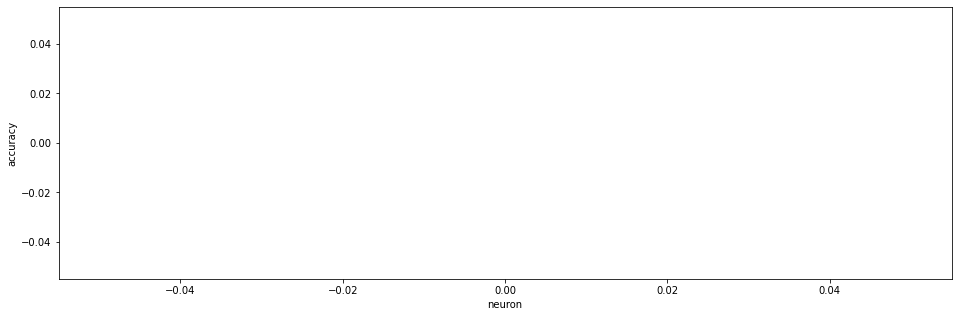

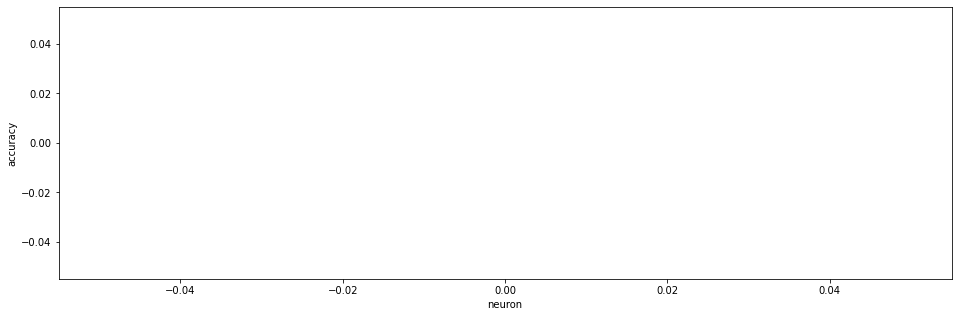

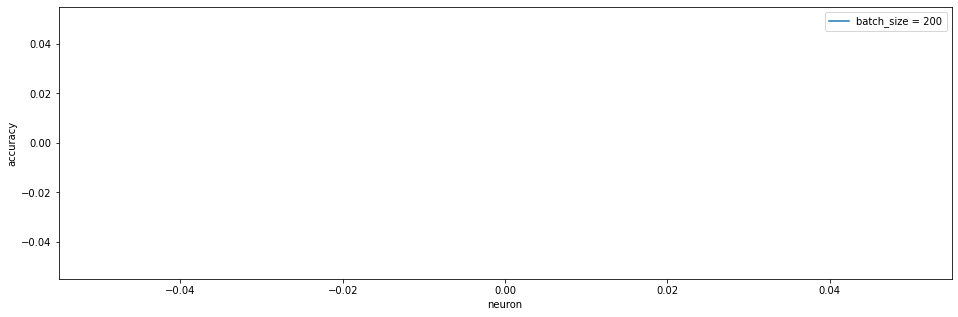

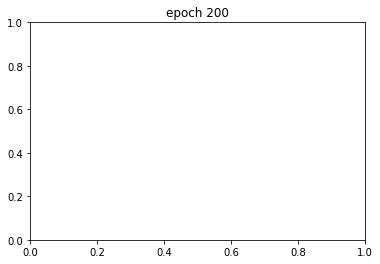

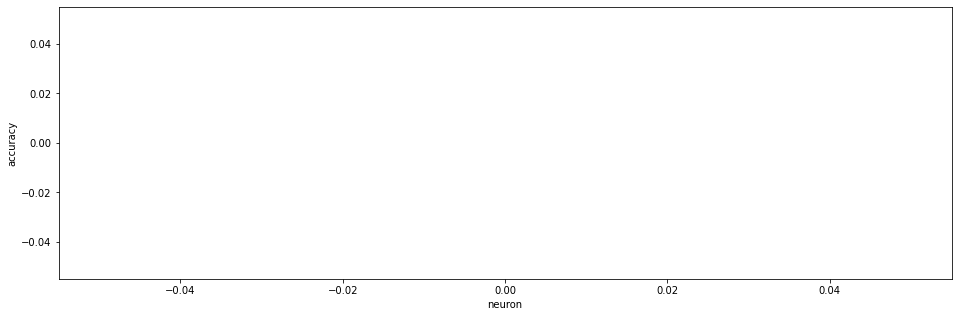

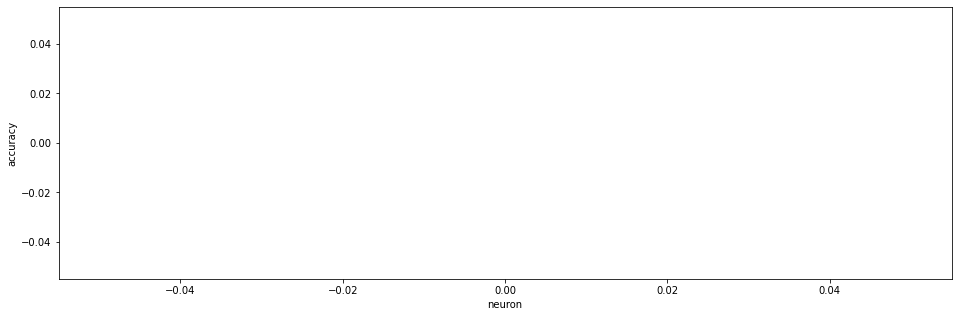

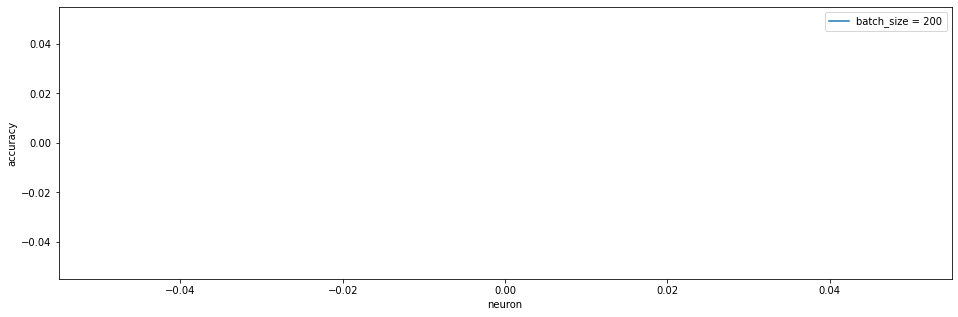

In [8]:
batch_size_list = [50, 100,200]
epoch_list = [100, 150, 200]
neuron_list=[64,128]
layerList_tail=[128,64,32,16]
Error_exp_=expirience(batch_size_list, epoch_list, neuron_list, layerList_tail)
plotter(epoch_list, batch_size_list, Error_exp_)

In [9]:
# Покажем нашУ модельку
model.summary()

NameError: ignored

In [37]:
# табличка !!!!
Error_exp_

,neuron,batch_size,epoch,error,accuracy
0,64.0,50.0,200.0,1.063472,0.623933
1,64.0,100.0,200.0,1.101926,0.609233
2,64.0,200.0,200.0,1.086813,0.617633
3,128.0,50.0,200.0,1.115201,0.608000
4,128.0,100.0,200.0,1.081523,0.619867
5,128.0,200.0,200.0,1.099859,0.610700


Вариант с layerList_tail=[128,64,32,16]

In [ ]:
batch_size_list = [50, 100,200]
epoch_list = [100, 150, 200]
neuron_list=[64,128]
layerList_tail=[128,64,32,16]
Error_exp_=expirience(batch_size_list, epoch_list, neuron_list, layerList_tail)
plotter(epoch_list, batch_size_list, Error_exp_)

# Анализ сводной таблицы и графики :

 - Нужно сделать больше экспериментов и посмотреть на конструкцию модели иначе


# Рекомендации:
стоит применить подход с использованием свёрток разной величины для увеличения комбинаторности свойств в свёрточных слоях

Серьезные ограничения накладываются на призводственные ресурсы. Colab отключает GPU после нескольких прогонов эксперимента. Исследования минимальных изменений архитектуры сети проходят до суток и более.